The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# **Importing libraries** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# **Reading the csv files**

In [2]:
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

# **item_categories**

In [3]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
item_categories.shape

(84, 2)

In [5]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


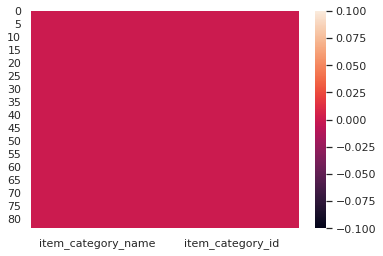

In [7]:
sns.heatmap(item_categories.isnull())
plt.show()

# **items**

In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
items.shape

(22170, 3)

In [10]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [11]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


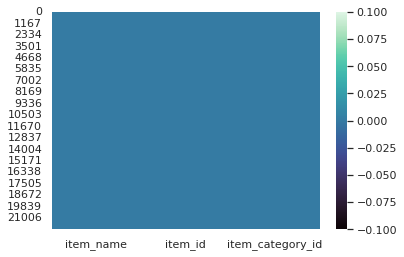

In [12]:
col1 = sns.color_palette("mako", as_cmap=True)
sns.heatmap(items.isnull(), cmap = col1)
plt.show()

# **Shops**

In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
shops.shape

(60, 2)

In [15]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [16]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


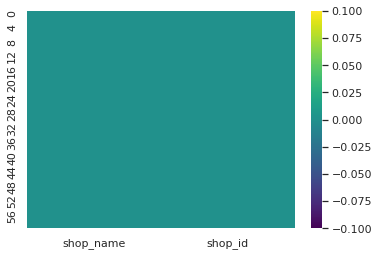

In [17]:
col2 = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(shops.isnull(), cmap = col2)
plt.show()

# **Train**

In [18]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [19]:
train.shape

(2935849, 6)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [21]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


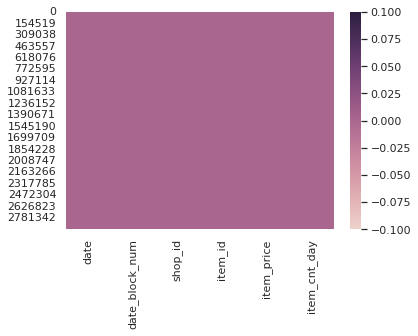

In [22]:
col3 = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(train.isnull(), cmap = col3)
plt.show()

# **Test**

In [23]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [24]:
test.shape

(214200, 3)

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [26]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


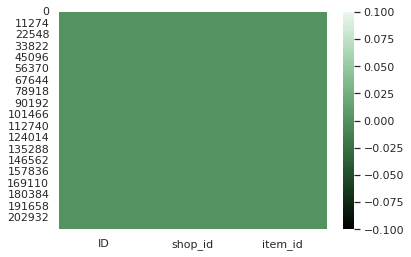

In [27]:
col4 = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.heatmap(test.isnull(), cmap = col4)
plt.show()

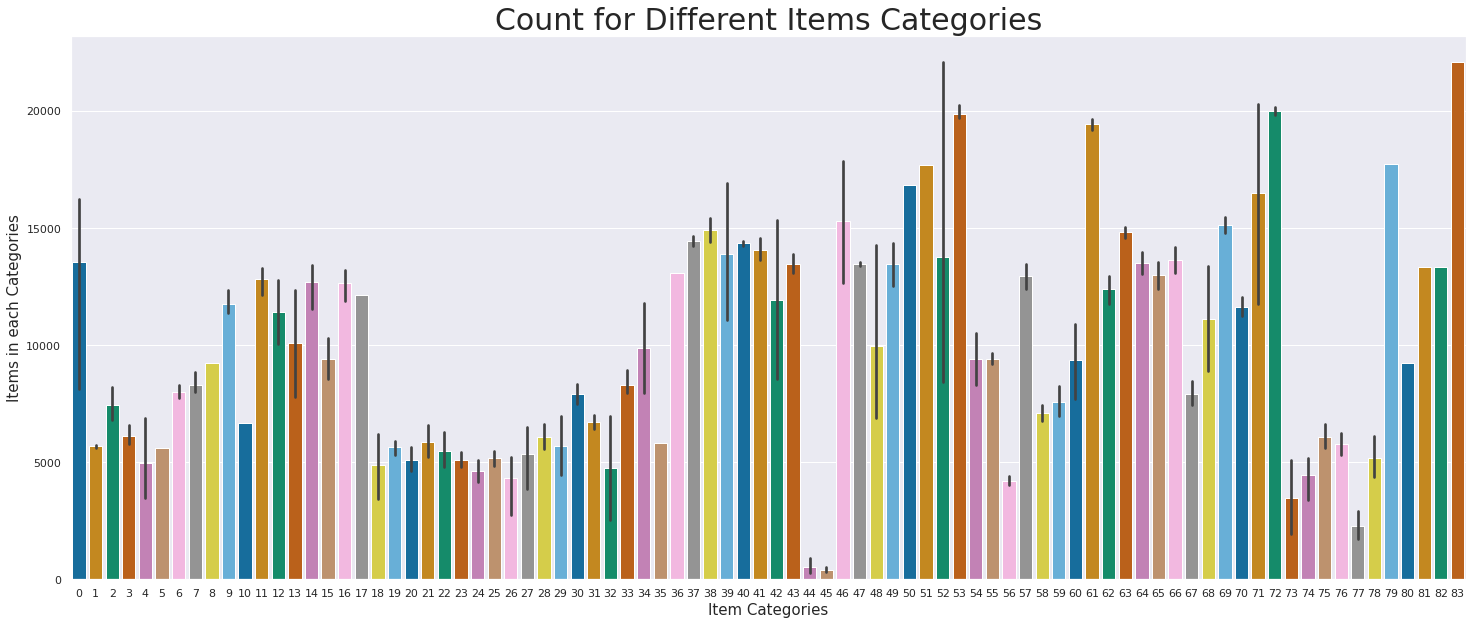

In [28]:
# Looking at the number of different categories

plt.rcParams['figure.figsize'] = (25,10)
sns.barplot(items['item_category_id'],items['item_id'], palette = 'colorblind')
plt.title('Count for Different Items Categories', fontsize = 30)
plt.xlabel("Item Categories", fontsize = 15)
plt.ylabel("Items in each Categories", fontsize = 15)
plt.show()

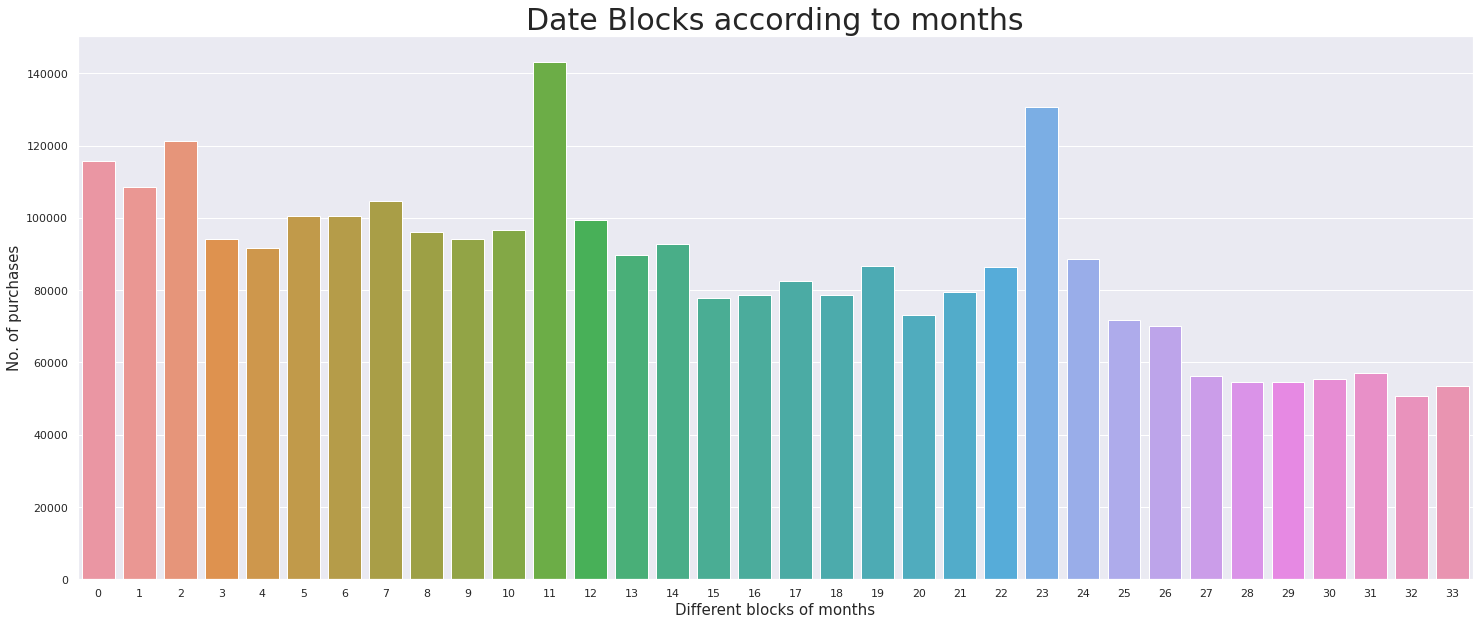

In [29]:
# having a look at the distribution of item sold per day

plt.rcParams["figure.figsize"] = (25,10)
sns.countplot(train['date_block_num'])
plt.title('Date Blocks according to months', fontsize = 30)
plt.xlabel("Different blocks of months", fontsize = 15)
plt.ylabel("No. of purchases", fontsize = 15)
plt.show()

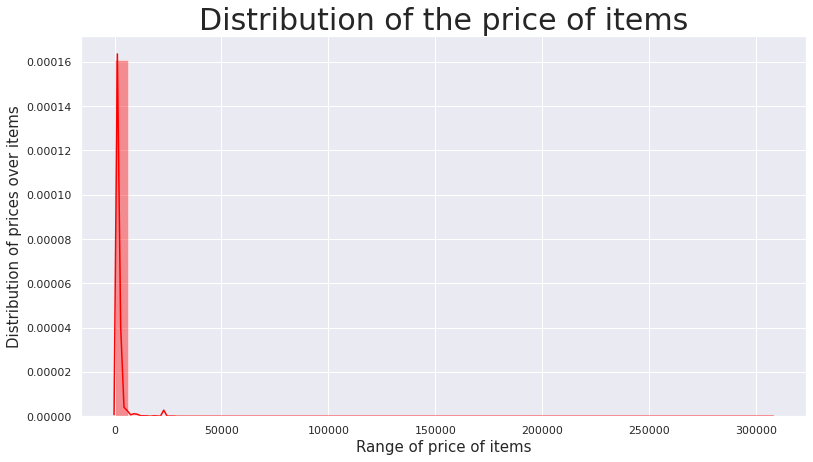

In [30]:
plt.rcParams["figure.figsize"] = (13,7)
sns.distplot(train["item_price"], color = "red")
plt.title('Distribution of the price of items',fontsize = 30)
plt.xlabel("Range of price of items", fontsize = 15)
plt.ylabel("Distribution of prices over items", fontsize = 15)
plt.show()

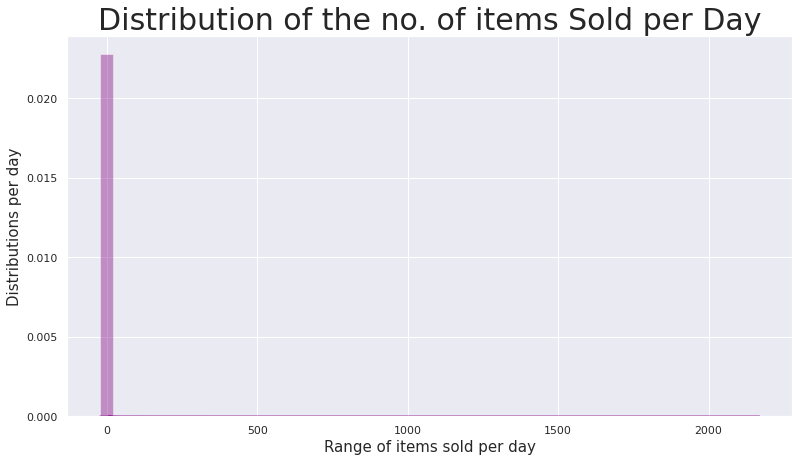

In [31]:
plt.rcParams["figure.figsize"] = (13,7)
sns.distplot(train["item_cnt_day"], color = "purple")
plt.title('Distribution of the no. of items Sold per Day',fontsize = 30)
plt.xlabel("Range of items sold per day", fontsize = 15)
plt.ylabel("Distributions per day", fontsize = 15)
plt.show()

In [32]:
# checking the no. of unique item present in the stores
x = train["item_id"].nunique()
print("The No. of Unique items present in the stores available",x)

The No. of Unique items present in the stores available 21807


In [33]:
# checking the no. of unique items categories present in the stores
x2 = item_categories["item_category_id"].nunique()
print("The No. of Unique items present in the stores available",x2)

The No. of Unique items present in the stores available 84


In [34]:
# checking the no. of unique shops given in the dataset
x3 = train["shop_id"].nunique()
print("The No. of Unique items present in the stores available",x3)

The No. of Unique items present in the stores available 60


# **Word cloud for Item Categories name**

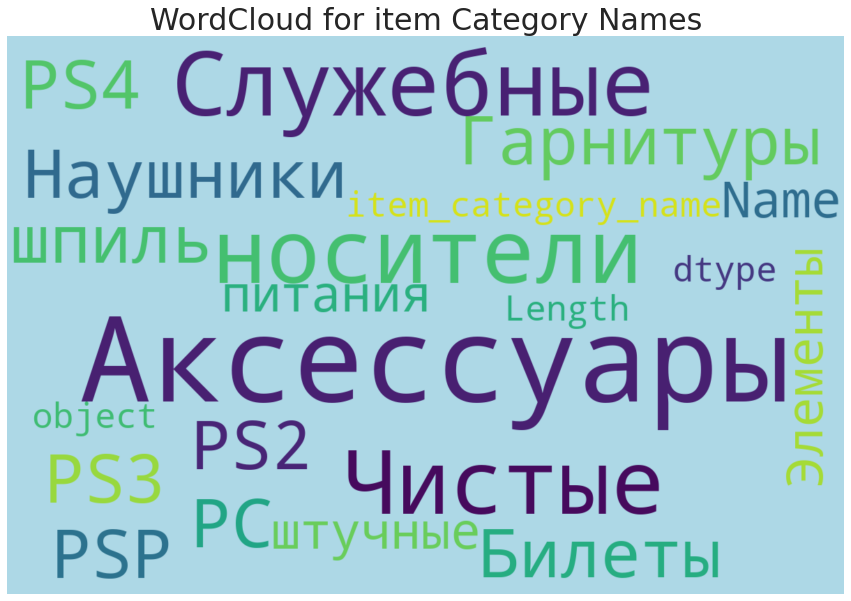

In [35]:
plt.rcParams["figure.figsize"] = (15,12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue',
                     max_words = 200, stopwords = stopwords,
                     width = 1200, height = 800, random_state = 42).\
generate(str(item_categories["item_category_name"]))
plt.title("WordCloud for item Category Names", fontsize = 30)
plt.axis("off")
plt.imshow(wordcloud, interpolation = "bilinear")
plt.show()

# **Word Cloud for Item Name**

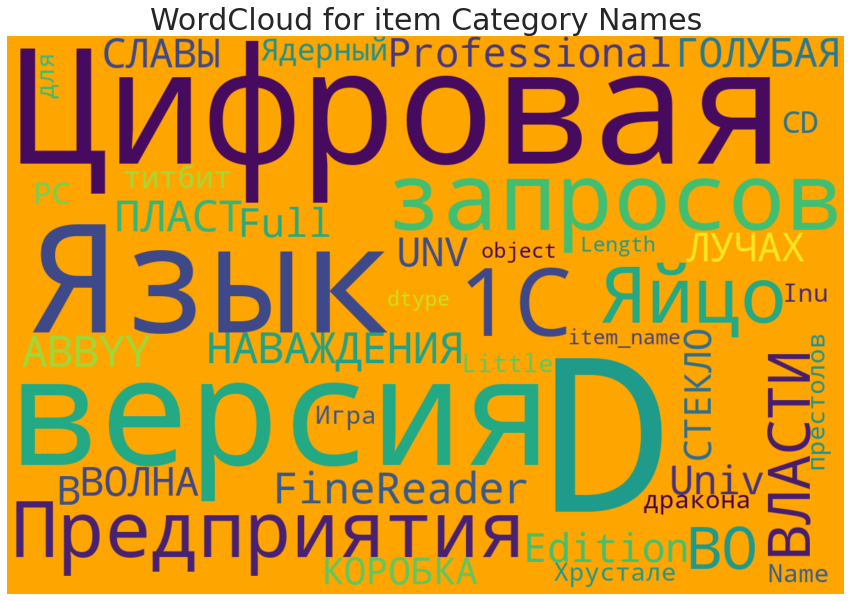

In [36]:
plt.rcParams["figure.figsize"] = (15,12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'orange',
                     max_words = 200, stopwords = stopwords,
                     width = 1200, height = 800, random_state = 42).\
generate(str(items["item_name"]))
plt.title("WordCloud for item Category Names", fontsize = 30)
plt.axis("off")
plt.imshow(wordcloud, interpolation = "bilinear")
plt.show()

# **Word Cloud for Shop Name**

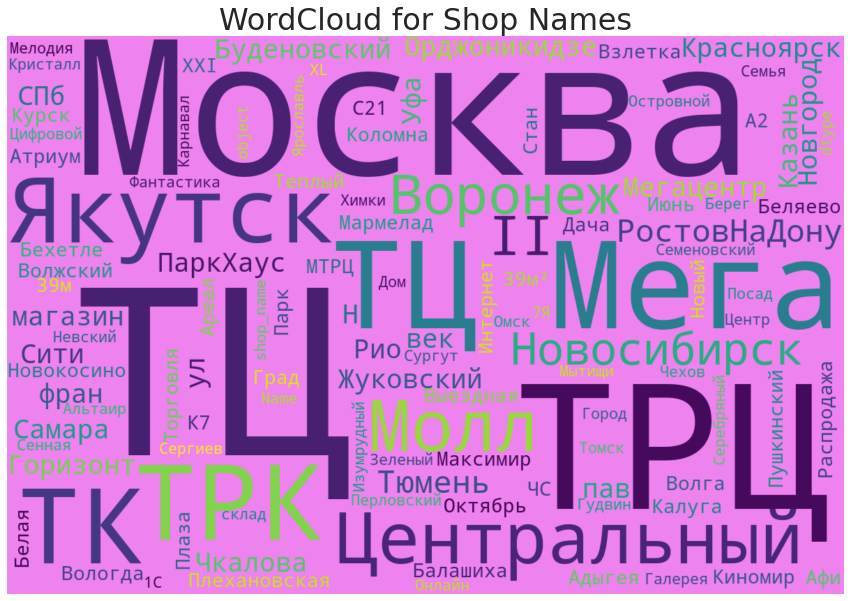

In [37]:
plt.rcParams["figure.figsize"] = (15,12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = "violet",
                     max_words = 200, stopwords = stopwords,
                     width = 1200, height = 800, random_state = 42).\
generate(str(shops["shop_name"]))
plt.title("WordCloud for Shop Names", fontsize = 30)
plt.axis("off")
plt.imshow(wordcloud, interpolation = "bilinear")
plt.show()

In [38]:
train['date'] = pd.to_datetime(train.date)

In [39]:
# making a new column day
train['day'] = train['date'].dt.day

# making a new column month
train['month'] = train['date'].dt.month

# making a new column year
train['year'] = train['date'].dt.year

# making a new column week
train['week'] = train['date'].dt.week

# checking the new columns
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'week'],
      dtype='object')

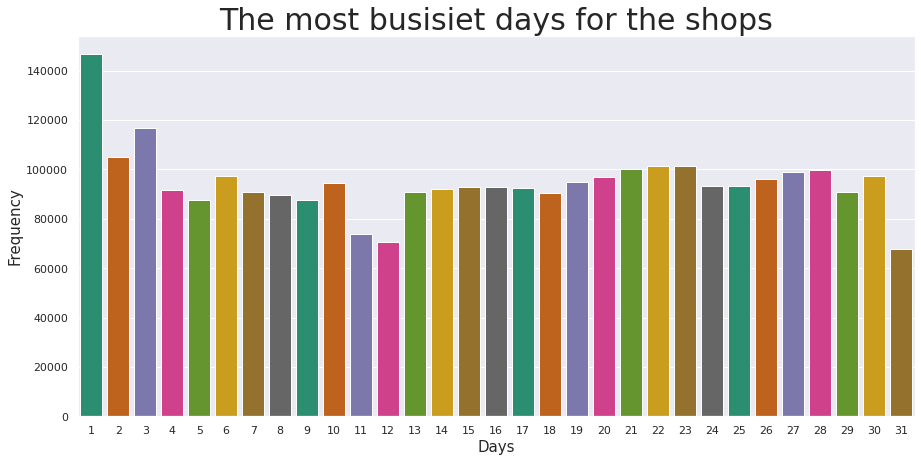

In [40]:
# checking which days are most busisiest for the shops

plt.rcParams["figure.figsize"] = (15,7)
sns.countplot(train['day'], palette = "Dark2")
plt.title('The most busisiet days for the shops', fontsize = 30)
plt.xlabel("Days", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.show()

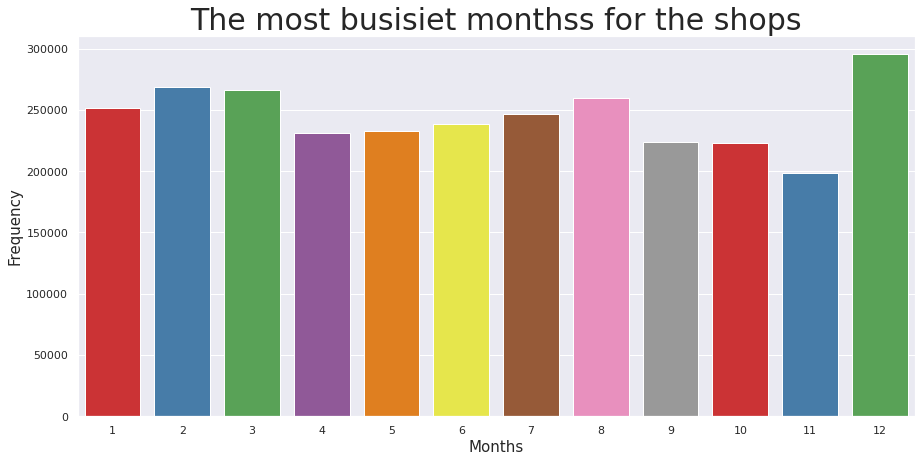

In [41]:
# checking which maonths are most busisiest for the shops

plt.rcParams["figure.figsize"] = (15,7)
sns.countplot(train['month'], palette = "Set1")
plt.title('The most busisiet monthss for the shops', fontsize = 30)
plt.xlabel("Months", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.show()

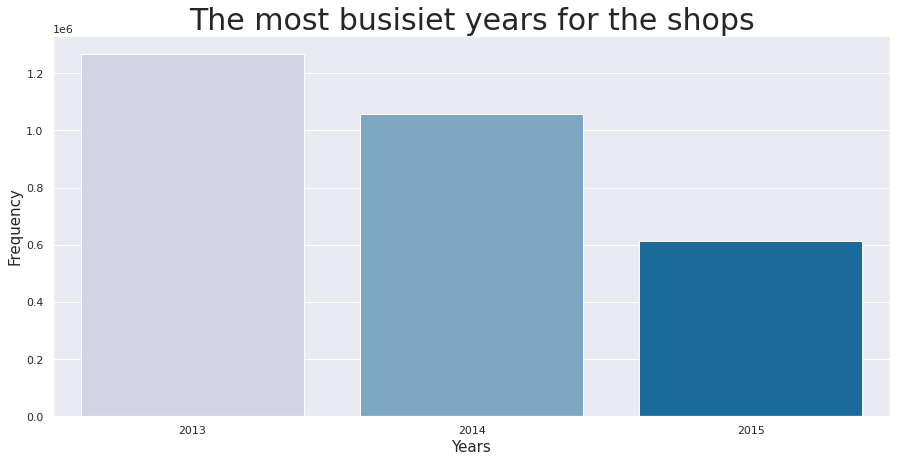

In [42]:
# checking which years are most busisiet for the shops

plt.rcParams["figure.figsize"] = (15,7)
sns.countplot(train['year'], palette = "PuBu")
plt.title('The most busisiet years for the shops', fontsize = 30)
plt.xlabel("Years", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.show()

# **Feature Enginnering**

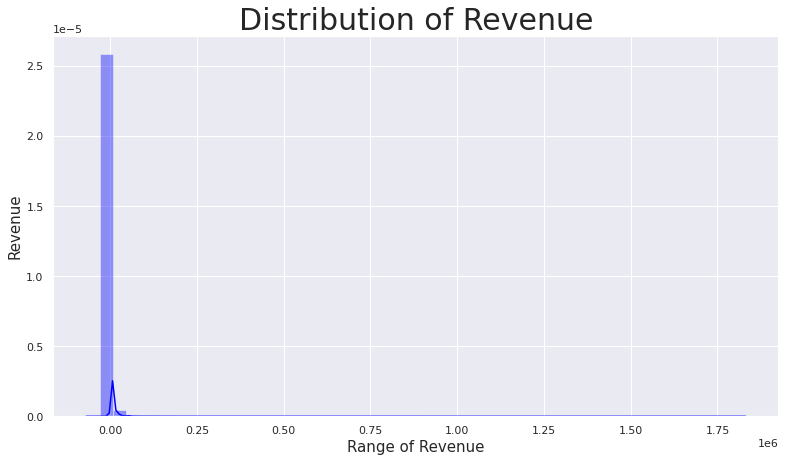

In [43]:
train["revenue"] = train["item_price"] * train["item_cnt_day"]
plt.rcParams["figure.figsize"] = (13,7)
sns.distplot(train["revenue"], color = "blue")
plt.title('Distribution of Revenue',fontsize = 30)
plt.xlabel("Range of Revenue", fontsize = 15)
plt.ylabel("Revenue", fontsize = 15)
plt.show()

In [44]:
train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
day                        int64
month                      int64
year                       int64
week                       int64
revenue                  float64
dtype: object

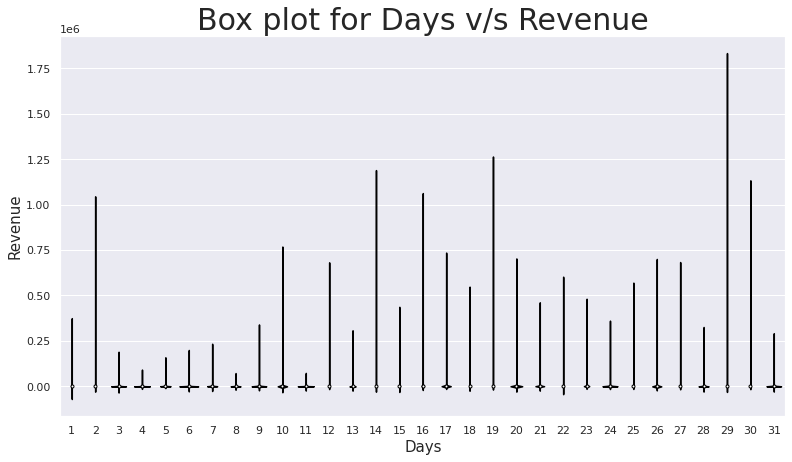

In [45]:
# plotting a violin plot for item price and item-cnt-day
plt.rcParams["figure.figsize"] = (13,7)
sns.violinplot(x = train["day"],y = train["revenue"], color = "black")
plt.title('Box plot for Days v/s Revenue',fontsize = 30)
plt.xlabel("Days", fontsize = 15)
plt.ylabel("Revenue", fontsize = 15)
plt.show()

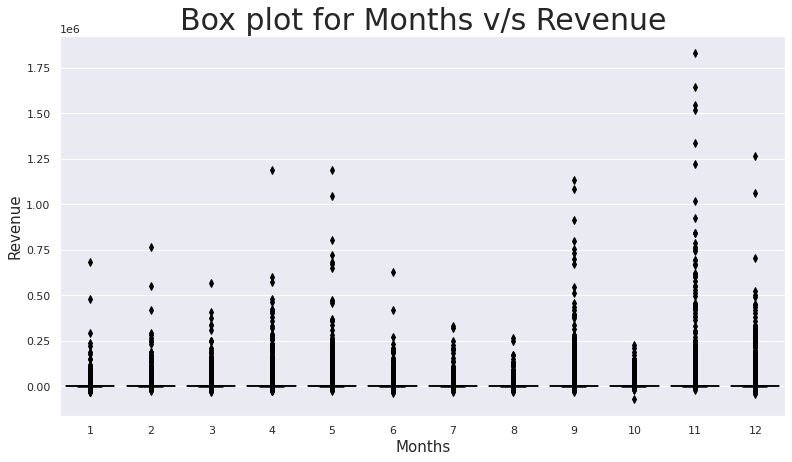

In [46]:
# plotting a box plot for item price and item-cnt-day
plt.rcParams["figure.figsize"] = (13,7)
sns.boxplot(x = train["month"],y = train["revenue"], color = "black")
plt.title('Box plot for Months v/s Revenue',fontsize = 30)
plt.xlabel("Months", fontsize = 15)
plt.ylabel("Revenue", fontsize = 15)
plt.show()

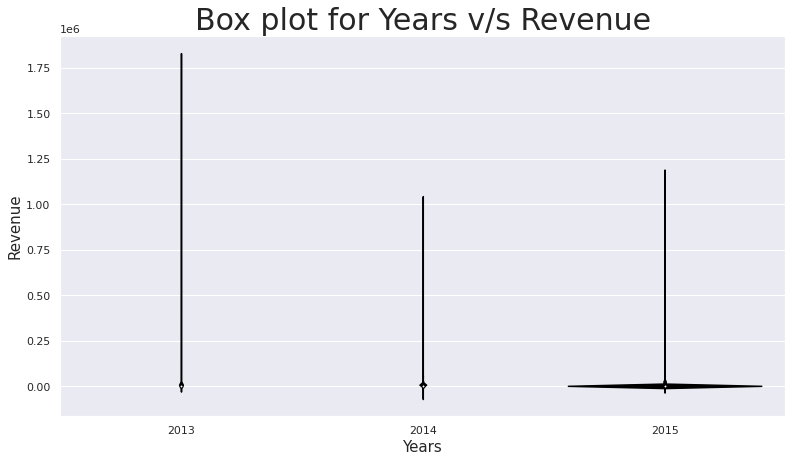

In [47]:
# plotting a box plot for item price and item-cnt-day
plt.rcParams["figure.figsize"] = (13,7)
sns.violinplot(x = train["year"],y = train["revenue"], color = "black")
plt.title('Box plot for Years v/s Revenue',fontsize = 30)
plt.xlabel("Years", fontsize = 15)
plt.ylabel("Revenue", fontsize = 15)
plt.show()

In [48]:
# coverting the data into monthly sales data
#making a dataset with only monthy sales data
data = train.groupby([train["date"].apply(lambda x:x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()

#specifying the important attributes which we want to add to the data
data =  data[["date","item_id","shop_id","item_cnt_day"]]

#at last we can select the specific attributes from the dataset which are important
data = data.pivot_table(index = ["item_id","shop_id"], columns = "date",
                       values = "item_cnt_day", fill_value = 0).reset_index()

#looking at the newly prepared dataset
data.shape

(424124, 38)

In [49]:
# lets merge the monthly sales data prepared to the test data set

test = pd.merge(test, data, on = ["item_id","shop_id"], how = "left")

#filling the empty values found in the dataset
test.fillna(0, inplace = True)

#checking the dataset
test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
test = test.drop(["2015-11","2015-12"], axis =1)

In [51]:
test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# now lets  create the actual training data

x_train = test.drop(["2015-10","item_id","shop_id"], axis = 1)
y_train = test["2015-10"]

#deleting the first column so that it can predict teh future sales data
x_test = test.drop(["2013-01","item_id","shop_id"], axis = 1)

#checking the shapes of the datasets
print("Shape of x_train", x_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_train", y_train.shape)

Shape of x_train (214200, 34)
Shape of x_test (214200, 34)
Shape of y_train (214200,)


In [53]:
x_train.head()

,ID,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
x_test.head()

,ID,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train, test_size = 0.2,
                                                     random_state = 0)

#checking the shapes of the datasets
print("Shape of x_train", x_train.shape)
print("Shape of x_valid", x_valid.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_valid", y_valid.shape)

Shape of x_train (171360, 34)
Shape of x_valid (42840, 34)
Shape of y_train (171360,)
Shape of y_valid (42840,)


# **Modeling**

In [56]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:2.45051	validation_1-rmse:11.12231
[1]	validation_0-rmse:2.40535	validation_1-rmse:11.09493
[2]	validation_0-rmse:2.37532	validation_1-rmse:11.07115
[3]	validation_0-rmse:2.35454	validation_1-rmse:11.05346
[4]	validation_0-rmse:2.33725	validation_1-rmse:11.03711
[5]	validation_0-rmse:2.32790	validation_1-rmse:11.02740
[6]	validation_0-rmse:2.31834	validation_1-rmse:11.01474
[7]	validation_0-rmse:2.31029	validation_1-rmse:11.00565
[8]	validation_0-rmse:2.30348	validation_1-rmse:10.99628
[9]	validation_0-rmse:2.29751	validation_1-rmse:10.98809
[10]	validation_0-rmse:2.29055	validation_1-rmse:10.97797
[11]	validation_0-rmse:2.28621	validation_1-rmse:10.97283
[12]	validation_0-rmse:2.28095	validation_1-rmse:10.96478
[13]	validation_0-rmse:2.27528	validation_1-rmse:10.95586
[14]	validation_0-rmse:2.27164	validation_1-rmse:10.95117
[15]	validation_0-rmse:2.26788	validation_1-rmse:10.94442
[16]	validation_0-rmse:2.26428	validation_1-rmse:10.93820
[17]	validation_0-rmse:2

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [57]:
Y_pred = model.predict(x_valid).clip(0, 20)
Y_test = model.predict(x_test).clip(0, 20)

In [58]:
#Creating the submission file and submit
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)